# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
# from ipywidgets import FloatProgress

In [5]:
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension


Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 138 kB 5.4 MB/s eta 0:00:01
     |████████████████████████████████| 2.1 MB 39.4 MB/s eta 0:00:01
     |████████████████████████████████| 198 kB 42.5 MB/s eta 0:00:01
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

# torch.cuda.is_available()

device(type='cpu')

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [3]:
# Define transforms
transform = transforms.Compose([transforms.RandomRotation(30),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(), 
                                transforms.Normalize((0.5,), (0.5,)),])

view_transform = transforms.Compose([transforms.RandomRotation(30),
                                transforms.RandomHorizontalFlip(), 
                                transforms.ToTensor()])

# Create view training set and define training dataloader
view_train_data=datasets.MNIST('data',train=True,download=True,transform=view_transform)
view_train_loader = DataLoader(view_train_data, batch_size=32)

# Create training set and define training dataloader
train_data=datasets.MNIST('data',train=True,download=True,transform=transform)
train_loader = DataLoader(train_data, batch_size=250, shuffle=True)

validation_data=datasets.MNIST('data',train=True,download=True,transform=transform)
validation_loader = DataLoader(validation_data, batch_size=32)

# Create test set and define test dataloader
test_data=datasets.MNIST('data',train=False,download=True,transform=transform)
test_loader = DataLoader(test_data, batch_size=32)

/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

I did data augmentation to make the model more robust to different writing styles and orientation. I also did normalization to make the pixel values to have consistant scale. Transforming into Tensor is unavoidable since neural networks in PyTorch uses Tensor.
While loading the training data, the data is shuffled to prevent bias occured by the ordering of the data. 

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [4]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
print("train_loader")
print(len(train_loader))
print(len(train_loader.dataset))
print(type(images))
print(images.shape)
print(labels.shape)



dataiter = iter(test_loader)
images, labels = dataiter.next()
print("test_loader")
print(len(test_loader))
print(type(images))
print(images.shape)
print(labels.shape)

train_loader
240
60000
<class 'torch.Tensor'>
torch.Size([250, 1, 28, 28])
torch.Size([250])
test_loader
313
<class 'torch.Tensor'>
torch.Size([32, 1, 28, 28])
torch.Size([32])


In [5]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

5


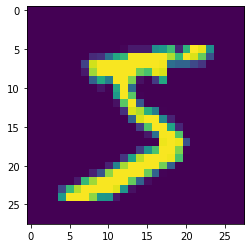

0


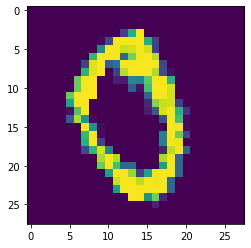

4


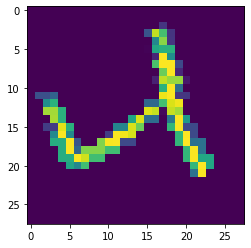

1


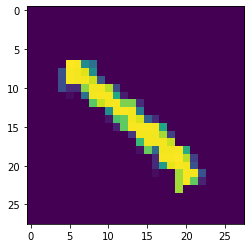

9


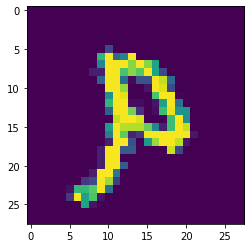

In [7]:
# Explore data
# Dataloader without normalization
show5(view_train_loader)

0


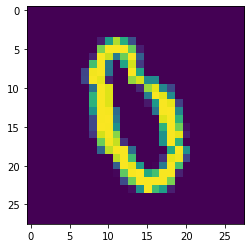

8


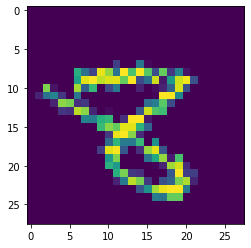

0


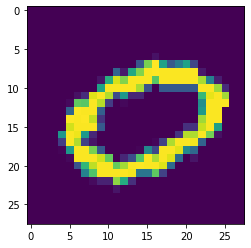

6


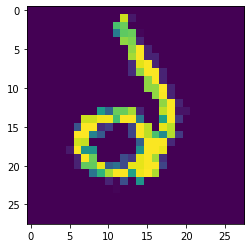

9


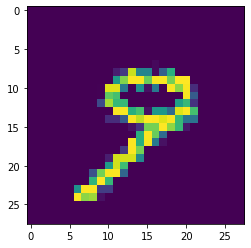

In [8]:
# Dataloader with normalization
show5(train_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [6]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = F.relu
        self.fc1=nn.Linear(28 * 28 * 1,256)
        self.fc2=nn.Linear(256,128)
        self.out=nn.Linear(128,10)

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.out(x)
        return x

# Instantiate the model
net = Net()
net.to(device)

Net(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=10, bias=True)
)

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [7]:
# optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)

# loss function
criterion = nn.CrossEntropyLoss()

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [ ]:
num_epochs = 20

# Establish a list for our history
train_loss_history = list()
val_loss_history = list()

for epoch in range(num_epochs):
    net.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    for i, data in enumerate(train_loader):

        # data is a list of [inputs, labels]
        inputs, labels = data

        # Pass to GPU if available.
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs.data, 1)
        train_correct += (preds == labels).sum().item()
        train_loss += loss.item()
        train_total += labels.shape[0]
        
    print(f'Epoch {epoch + 1} training accuracy: {train_correct/train_total:.2f}% training loss: {train_loss/len(train_loader):.5f}')
    train_loss_history.append(train_loss/len(train_loader))
    
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    net.eval()
    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = net(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs.data, 1)
            val_correct += (preds == labels).sum().item()
            val_loss += loss.item()
            val_total += labels.shape[0]
    print(f'Epoch {epoch + 1} validation accuracy: {val_correct/val_total:.2f}% validation loss: {val_loss/len(validation_loader):.5f}')
    val_loss_history.append(val_loss/len(validation_loader))


Epoch 1 training accuracy: 0.73% training loss: 0.82958
Epoch 1 validation accuracy: 0.81% validation loss: 0.60887
Epoch 2 training accuracy: 0.84% training loss: 0.50421
Epoch 2 validation accuracy: 0.86% validation loss: 0.42254
Epoch 3 training accuracy: 0.88% training loss: 0.39107
Epoch 3 validation accuracy: 0.88% validation loss: 0.36776
Epoch 4 training accuracy: 0.90% training loss: 0.32742
Epoch 4 validation accuracy: 0.91% validation loss: 0.29490
Epoch 5 training accuracy: 0.91% training loss: 0.29069
Epoch 5 validation accuracy: 0.91% validation loss: 0.28156
Epoch 6 training accuracy: 0.92% training loss: 0.26697
Epoch 6 validation accuracy: 0.92% validation loss: 0.24363
Epoch 7 training accuracy: 0.92% training loss: 0.25343
Epoch 7 validation accuracy: 0.92% validation loss: 0.24176
Epoch 8 training accuracy: 0.93% training loss: 0.23250
Epoch 8 validation accuracy: 0.93% validation loss: 0.22104
Epoch 9 training accuracy: 0.93% training loss: 0.22176
Epoch 9 validati

Plot the training loss (and validation loss/accuracy, if recorded).

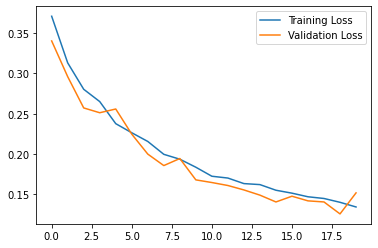

In [19]:
# Plot the training and validation loss history
plt.plot(train_loss_history, label="Training Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.legend()
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [20]:
correct_item = 0
total_item = 0
net.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs.data, 1)
        correct_item += (preds == labels).sum().item()
        total_item += labels.size(0)
    
print(f"Validation Accuracy: {(correct_item/total_item) * 100 :.3f}%")

Validation Accuracy: 94.850%


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [8]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = F.relu
        self.dropout = nn.Dropout(0.2)
        self.fc1=nn.Linear(28 * 28 * 1,512)
        self.fc2=nn.Linear(512,256)
        self.fc3=nn.Linear(256,128)
        self.out=nn.Linear(128,10)


    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.activation(self.fc2(x))
        x = self.dropout(x)
        x = self.activation(self.fc3(x))
        x = self.dropout(x)
        x = self.out(x)
        return x

# Instantiate the model
net = Net()
net.to(device)

Net(
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=10, bias=True)
)

In [9]:
# optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

# loss function
criterion = nn.CrossEntropyLoss()

In [10]:
num_epochs = 30

# Establish a list for our history
train_loss_history = list()
val_loss_history = list()

for epoch in range(num_epochs):
    net.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    for i, data in enumerate(train_loader):

        # data is a list of [inputs, labels]
        inputs, labels = data

        # Pass to GPU if available.
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs.data, 1)
        train_correct += (preds == labels).sum().item()
        train_loss += loss.item()
        train_total += labels.shape[0]
        
    print(f'Epoch {epoch + 1} training accuracy: {train_correct/train_total:.2f}% training loss: {train_loss/len(train_loader):.5f}')
    train_loss_history.append(train_loss/len(train_loader))
    
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    net.eval()
    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = net(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs.data, 1)
            val_correct += (preds == labels).sum().item()
            val_loss += loss.item()
            val_total += labels.shape[0]
    print(f'Epoch {epoch + 1} validation accuracy: {val_correct/val_total:.2f}% validation loss: {val_loss/len(validation_loader):.5f}')
    val_loss_history.append(val_loss/len(validation_loader))


Epoch 1 training accuracy: 0.51% training loss: 1.42037
Epoch 1 validation accuracy: 0.74% validation loss: 0.75406
Epoch 2 training accuracy: 0.75% training loss: 0.74622
Epoch 2 validation accuracy: 0.81% validation loss: 0.58556
Epoch 3 training accuracy: 0.80% training loss: 0.59950
Epoch 3 validation accuracy: 0.85% validation loss: 0.47303
Epoch 4 training accuracy: 0.84% training loss: 0.49999
Epoch 4 validation accuracy: 0.87% validation loss: 0.40232
Epoch 5 training accuracy: 0.86% training loss: 0.43246
Epoch 5 validation accuracy: 0.89% validation loss: 0.33723
Epoch 6 training accuracy: 0.88% training loss: 0.38298
Epoch 6 validation accuracy: 0.91% validation loss: 0.29512
Epoch 7 training accuracy: 0.89% training loss: 0.35167
Epoch 7 validation accuracy: 0.91% validation loss: 0.27860
Epoch 8 training accuracy: 0.90% training loss: 0.32542
Epoch 8 validation accuracy: 0.92% validation loss: 0.25876
Epoch 9 training accuracy: 0.90% training loss: 0.30938
Epoch 9 validati

In [11]:
correct_item = 0
total_item = 0
net.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs.data, 1)
        correct_item += (preds == labels).sum().item()
        total_item += labels.size(0)
    
print(f"Validation Accuracy: {(correct_item/total_item) * 100 :.3f}%")

Validation Accuracy: 95.980%


## Saving your model
Using `torch.save`, save your model for future loading.

In [15]:
net.state_dict()

OrderedDict([('fc1.weight',
              tensor([[ 0.0104, -0.0311, -0.0098,  ..., -0.0038, -0.0201, -0.0046],
                      [ 0.0191,  0.0280, -0.0315,  ..., -0.0141,  0.0099, -0.0129],
                      [ 0.0358,  0.0060, -0.0257,  ...,  0.0193, -0.0264, -0.0168],
                      ...,
                      [-0.0215,  0.0321,  0.0240,  ...,  0.0050, -0.0131,  0.0347],
                      [-0.0061, -0.0025,  0.0326,  ..., -0.0327,  0.0202, -0.0273],
                      [-0.0332,  0.0179,  0.0130,  ..., -0.0084,  0.0332,  0.0154]])),
             ('fc1.bias',
              tensor([ 7.5936e-03, -3.0194e-02, -3.2045e-02, -2.4491e-02,  2.2543e-02,
                      -2.4224e-02,  7.5858e-03, -3.5318e-04, -2.4032e-02,  8.5844e-03,
                       1.2108e-02,  1.1326e-02,  1.0217e-02,  3.0163e-02,  5.2865e-03,
                      -2.9226e-02, -8.4271e-03, -1.4788e-02,  2.1086e-02,  1.1380e-02,
                      -1.1355e-02,  1.4157e-02, -4.7043e-02, -1.

In [16]:
optimizer.state_dict()

{'state': {0: {'momentum_buffer': tensor([[-5.2050e-04, -5.2050e-04, -5.2050e-04,  ..., -5.2050e-04,
            -5.2050e-04, -5.2050e-04],
           [-5.1437e-16, -5.1437e-16, -5.1437e-16,  ..., -5.1437e-16,
            -5.1437e-16, -5.1437e-16],
           [-9.3781e-03, -9.3781e-03, -9.3781e-03,  ..., -9.3781e-03,
            -9.3781e-03, -9.3781e-03],
           ...,
           [-1.2903e-02, -1.2903e-02, -1.2903e-02,  ..., -1.2903e-02,
            -1.2903e-02, -1.2903e-02],
           [ 1.1058e-02,  1.1058e-02,  1.1058e-02,  ...,  1.1058e-02,
             1.1058e-02,  1.1058e-02],
           [-9.1211e-09, -9.1211e-09, -9.1211e-09,  ..., -9.1211e-09,
            -9.1211e-09, -9.1211e-09]])},
  1: {'momentum_buffer': tensor([ 5.2050e-04,  5.1437e-16,  9.3781e-03, -4.0149e-03, -1.3339e-03,
            8.8022e-04, -9.9626e-10,  1.9993e-03, -2.1863e-03,  5.1336e-03,
           -4.6081e-10,  5.9265e-03, -7.8253e-03, -2.3317e-08,  2.1419e-03,
           -5.1421e-03, -8.3356e-03,  9.1227e-

In [17]:
checkpoint = {
    'model': net,
    'state_dict': net.state_dict(),
    'optimizer_dict': optimizer.state_dict(),
}
torch.save(checkpoint, 'checkpoint.pth')